<a href="https://colab.research.google.com/github/Shivdutta/EIP4/blob/master/Assignment5/PersonAttrubutes125.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [3]:
%tensorflow_version 1.x
!pip install bokeh
import cv2
import json
from keras.callbacks import ModelCheckpoint
from keras.callbacks import *
import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16,InceptionV3, ResNet50V2
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam,SGD,RMSprop
from keras.preprocessing.image import ImageDataGenerator
import keras
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

Using TensorFlow backend.


In [4]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [5]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.augmentation = augmentation
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [7]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [8]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
925,resized/926.jpg,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0
7492,resized/7493.jpg,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0
11285,resized/11287.jpg,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4174,resized/4175.jpg,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0
9489,resized/9490.jpg,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0


In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32)
valid_gen = PersonDataGenerator(train_df, batch_size=64, shuffle=False)

In [10]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [11]:
backbone = ResNet50V2(
    weights=None, 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# freeze backbone
#for layer in backbone.layers:
#	layer.trainable = False

In [12]:
# losses = {
# 	"gender_output": "binary_crossentropy",
# 	"image_quality_output": "categorical_crossentropy",
# 	"age_output": "categorical_crossentropy",
# 	"weight_output": "categorical_crossentropy",

# }
# loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
opt = SGD(lr=0.001, momentum=0.9)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

import os
# Prepare model model saving directory.
#save_dir = os.path.join(os.getcwd(), 'saved_models')
save_dir = '/content/gdrive/My Drive/Colab Notebooks/'
model_name5 = 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'

print(save_dir)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name5)

print(filepath)

#filepath="/content/drive/My Drive/saved weights/weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss', verbose=1, save_best_only=True) 
#/content/gdrive/My Drive/saved weights
#/content/gdrive/My Drive/Colab Notebooks



/content/gdrive/My Drive/Colab Notebooks/
/content/gdrive/My Drive/Colab Notebooks/weights.{epoch:02d}-{val_loss:.2f}.hdf5


In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
def find_lr(model, start_lr, end_lr):
    finder = LRFinder(start_lr, end_lr, len(train_gen))
    weights = model.get_weights()    
    try:
        history = model.fit_generator(
            generator=train_gen,
            validation_data=valid_gen,
            epochs=1,
            verbose=1,
            callbacks=[finder],
        )   
    finally:    
        model.set_weights(weights)    
    return finder
    
class LRFinder(Callback):    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)        
        
        K.set_value(self.model.optimizer.lr, lr)  

    def plot(self, lskip=10, rskip=10):
        lrs = self.lrs[lskip:-rskip]
        losses = self.smoothed_losses[lskip:-rskip]

        output_notebook()
        p = figure(title='Learning Rate Finder', x_axis_label='LR', y_axis_label='Loss')
        p.line(lrs, losses)
        show(p)
        
        best_idxs = np.argpartition(losses, 15)[:15]
        best_lrs = np.take(lrs, best_idxs)
        print(f"Best LRs: {best_lrs}")    
#Cyclic Learning Rate
class CyclicLR(Callback):
  

    def __init__(self, base_lr=0.00000005, max_lr=0.009, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [15]:
opt = SGD()
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
      
    metrics=["accuracy"]
)
finder = find_lr(model, 0.000003, 0.00003)
finder.plot()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
360/360 [==============================] - 372s 1s/step - loss: 9.8630 - gender_output_loss: 0.8098 - image_quality_output_loss: 1.1945 - age_output_loss: 1.7208 - weight_output_loss: 1.3028 - bag_output_loss: 1.2685 - footwear_output_loss: 1.2975 - pose_output_loss: 1.1459 - emotion_output_loss: 1.1232 - gender_output_acc: 0.5098 - image_quality_output_acc: 0.3923 - age_output_acc: 0.2577 - weight_output_acc: 0.4462 - bag_output_acc: 0.3907 - footwear_output_acc: 0.3756 - pose_output_acc: 0.4490 - emotion_output_acc: 0.6004 - val_loss: 8.5418 - val_gender_output_loss: 0.7543 - val_image_quality_output_loss: 1.0574 - val_age_output_loss: 1.5375 - val_weight_output_loss: 1.0669 - val_bag_output_loss: 1.0182 - val_footwear_output_loss: 1.1235 - val_pose_output_loss: 0.9998 - val_emotion_output_loss: 0.9842 - val_gender_output_acc: 0.5330 - val_image_quality_output_acc: 0.5212 - val_a

Best LRs: [2.65670588e-05 2.81412560e-05 2.76064233e-05 2.79618370e-05
 2.63976763e-05 2.77835618e-05 2.72555273e-05 2.70817553e-05
 2.69090913e-05 2.74304142e-05 2.62293737e-05 2.58959809e-05
 2.67375281e-05 2.52418542e-05 2.55668257e-05]


In [16]:
opt = RMSprop()
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
      
    metrics=["accuracy"]
)
finder = find_lr(model, 0.000003, 0.00003)
finder.plot()

Epoch 1/1
360/360 [==============================] - 387s 1s/step - loss: 8.4211 - gender_output_loss: 0.7306 - image_quality_output_loss: 1.0425 - age_output_loss: 1.5257 - weight_output_loss: 1.0726 - bag_output_loss: 0.9957 - footwear_output_loss: 1.0697 - pose_output_loss: 0.9950 - emotion_output_loss: 0.9893 - gender_output_acc: 0.5333 - image_quality_output_acc: 0.5001 - age_output_acc: 0.3446 - weight_output_acc: 0.5931 - bag_output_acc: 0.5046 - footwear_output_acc: 0.4658 - pose_output_acc: 0.5827 - emotion_output_acc: 0.7020 - val_loss: 8.1430 - val_gender_output_loss: 0.6895 - val_image_quality_output_loss: 0.9818 - val_age_output_loss: 1.5479 - val_weight_output_loss: 0.9912 - val_bag_output_loss: 0.9497 - val_footwear_output_loss: 1.0397 - val_pose_output_loss: 0.9355 - val_emotion_output_loss: 1.0075 - val_gender_output_acc: 0.5476 - val_image_quality_output_acc: 0.5552 - val_age_output_acc: 0.3986 - val_weight_output_acc: 0.6346 - val_bag_output_acc: 0.5094 - val_footwea

Best LRs: [1.86881237e-05 2.27864574e-05 2.23533942e-05 2.29326682e-05
 1.90501778e-05 1.89287203e-05 1.88080373e-05 2.41366399e-05
 2.16498349e-05 2.26411787e-05 2.32279105e-05 2.24968263e-05
 2.22108766e-05 2.09684196e-05 1.84505851e-05]


In [14]:
# add image augmentation
train_gen = PersonDataGenerator(
    train_df, 
    augmentation=ImageDataGenerator(
        zca_whitening=True,
        horizontal_flip=True,
        vertical_flip=False,
    )
)
clr_triangular = CyclicLR(0.000003, 0.00003,mode='triangular')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [30]:
history=model.fit_generator(  
    steps_per_epoch=20000 // 32,  validation_steps=2000 // 64,
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=8, 
    epochs=25,
    verbose=1,callbacks=[checkpoint,clr_triangular]
)

Epoch 1/25

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '



625/625 [==============================] - 316s 506ms/step - loss: 8.0295 - gender_output_loss: 0.6953 - image_quality_output_loss: 1.0045 - age_output_loss: 1.4744 - weight_output_loss: 1.0135 - bag_output_loss: 0.9440 - footwear_output_loss: 1.0064 - pose_output_loss: 0.9500 - emotion_output_loss: 0.9413 - gender_output_acc: 0.5465 - image_quality_output_acc: 0.5320 - age_output_acc: 0.3639 - weight_output_acc: 0.6283 - bag_output_acc: 0.5366 - footwear_output_acc: 0.5072 - pose_output_acc: 0.6114 - emotion_output_acc: 0.7083 - val_loss: 7.9175 - val_gender_output_loss: 0.6899 - val_image_quality_output_loss: 0.9995 - val_age_output_loss: 1.4512 - val_weight_output_loss: 0.9910 - val_bag_output_loss: 0.9491 - val_footwear_output_loss: 0.9755 - val_pose_output_loss: 0.9467 - val_emotion_output_loss: 0.9146 - val_gender_output_acc: 0.5630 - val_image_quality_output_acc: 0.5418 - val_age_output_acc: 0.3735 - val_weight_output_acc: 0.6447 - val_bag_output_acc: 0.5509 - val_footwear_outp

In [15]:
M1 = keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/weights.25-6.83.hdf5")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [18]:
# add image augmentation
train_gen = PersonDataGenerator(
    train_df, 
    augmentation=ImageDataGenerator(
        zca_whitening=True,
        horizontal_flip=True,
        vertical_flip=False,
    )
)
clr_triangular1 = CyclicLR(0.000003, 0.00003,mode='triangular2')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [26]:
history1=M1.fit_generator(  
    steps_per_epoch=20000 // 32,  validation_steps=2000 // 64,
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=8, 
    epochs=25,
    verbose=1,callbacks=[checkpoint,clr_triangular1]
)

Epoch 1/25
625/625 [==============================] - 505s 808ms/step - loss: 7.1235 - gender_output_loss: 0.5759 - image_quality_output_loss: 0.9327 - age_output_loss: 1.3368 - weight_output_loss: 0.9228 - bag_output_loss: 0.8422 - footwear_output_loss: 0.8282 - pose_output_loss: 0.8345 - emotion_output_loss: 0.8503 - gender_output_acc: 0.6915 - image_quality_output_acc: 0.5694 - age_output_acc: 0.4268 - weight_output_acc: 0.6417 - bag_output_acc: 0.6119 - footwear_output_acc: 0.6239 - pose_output_acc: 0.6354 - emotion_output_acc: 0.7118 - val_loss: 6.8647 - val_gender_output_loss: 0.5594 - val_image_quality_output_loss: 0.9093 - val_age_output_loss: 1.3080 - val_weight_output_loss: 0.8961 - val_bag_output_loss: 0.8064 - val_footwear_output_loss: 0.7776 - val_pose_output_loss: 0.7816 - val_emotion_output_loss: 0.8262 - val_gender_output_acc: 0.7238 - val_image_quality_output_acc: 0.5741 - val_age_output_acc: 0.4395 - val_weight_output_acc: 0.6517 - val_bag_output_acc: 0.6492 - val_foo

In [28]:
results = M1.evaluate_generator(train_gen, verbose=1)
dict(zip(M1.metrics_names, results))

360/360 [==============================] - 87s 243ms/step


{'age_output_acc': 0.70859375,
 'age_output_loss': 0.8727107271552086,
 'bag_output_acc': 0.83125,
 'bag_output_loss': 0.4881379950377676,
 'emotion_output_acc': 0.7637152777777778,
 'emotion_output_loss': 0.5399200726714399,
 'footwear_output_acc': 0.8845486111111112,
 'footwear_output_loss': 0.4204764974613984,
 'gender_output_acc': 0.9375868055555555,
 'gender_output_loss': 0.24807481525672806,
 'image_quality_output_acc': 0.7455729166666667,
 'image_quality_output_loss': 0.6461314820581012,
 'loss': 4.2890870538022785,
 'pose_output_acc': 0.8578125,
 'pose_output_loss': 0.4402815341121621,
 'weight_output_acc': 0.7383680555555555,
 'weight_output_loss': 0.6333539440400071}

In [29]:
results = M1.evaluate_generator(valid_gen, verbose=1)
dict(zip(M1.metrics_names, results))

180/180 [==============================] - 81s 449ms/step


{'age_output_acc': 0.70859375,
 'age_output_loss': 0.8726517246829139,
 'bag_output_acc': 0.8314236111111111,
 'bag_output_loss': 0.48772969444592795,
 'emotion_output_acc': 0.7638888888888888,
 'emotion_output_loss': 0.5396881694595019,
 'footwear_output_acc': 0.8845486111111112,
 'footwear_output_loss': 0.4205088974701034,
 'gender_output_acc': 0.9375868055555555,
 'gender_output_loss': 0.24800850003957747,
 'image_quality_output_acc': 0.7456597222222222,
 'image_quality_output_loss': 0.6458995547559526,
 'loss': 4.288211913903554,
 'pose_output_acc': 0.8575520833333333,
 'pose_output_loss': 0.44058525678184296,
 'weight_output_acc': 0.7385416666666667,
 'weight_output_loss': 0.6331400965650876}

In [0]:
M2 = keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/weights.25-6.83.hdf5")

In [30]:
# add image augmentation
train_gen = PersonDataGenerator(
    train_df, 
    augmentation=ImageDataGenerator(
        zca_whitening=True,
        horizontal_flip=True,
        vertical_flip=False,
    )
)
clr_triangular2 = CyclicLR(0.000003, 0.00003,mode='exp_range')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [31]:
history2=M2.fit_generator(  
    steps_per_epoch=20000 // 32,  validation_steps=2000 // 64,
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=8, 
    epochs=25,
    verbose=1,callbacks=[checkpoint,clr_triangular2]
)

Epoch 1/25
625/625 [==============================] - 152s 243ms/step - loss: 7.0529 - gender_output_loss: 0.5676 - image_quality_output_loss: 0.9275 - age_output_loss: 1.3268 - weight_output_loss: 0.9230 - bag_output_loss: 0.8343 - footwear_output_loss: 0.8063 - pose_output_loss: 0.8236 - emotion_output_loss: 0.8438 - gender_output_acc: 0.6991 - image_quality_output_acc: 0.5679 - age_output_acc: 0.4308 - weight_output_acc: 0.6398 - bag_output_acc: 0.6180 - footwear_output_acc: 0.6363 - pose_output_acc: 0.6386 - emotion_output_acc: 0.7117 - val_loss: 6.7941 - val_gender_output_loss: 0.5359 - val_image_quality_output_loss: 0.9050 - val_age_output_loss: 1.2738 - val_weight_output_loss: 0.8994 - val_bag_output_loss: 0.7921 - val_footwear_output_loss: 0.7710 - val_pose_output_loss: 0.7779 - val_emotion_output_loss: 0.8390 - val_gender_output_acc: 0.7495 - val_image_quality_output_acc: 0.5741 - val_age_output_acc: 0.4556 - val_weight_output_acc: 0.6346 - val_bag_output_acc: 0.6391 - val_foo

In [32]:
results = M2.evaluate_generator(train_gen, verbose=1)
dict(zip(M2.metrics_names, results))

360/360 [==============================] - 27s 74ms/step


{'age_output_acc': 0.9067708333333333,
 'age_output_loss': 0.4942040243910419,
 'bag_output_acc': 0.9324652777777778,
 'bag_output_loss': 0.26324826897018483,
 'emotion_output_acc': 0.9052951388888889,
 'emotion_output_loss': 0.30498707339995434,
 'footwear_output_acc': 0.9671875,
 'footwear_output_loss': 0.20336848348379136,
 'gender_output_acc': 0.9855034722222222,
 'gender_output_loss': 0.11287220774425401,
 'image_quality_output_acc': 0.9051215277777778,
 'image_quality_output_loss': 0.3909994073212147,
 'loss': 2.3457787493864695,
 'pose_output_acc': 0.9782118055555555,
 'pose_output_loss': 0.19464567562358248,
 'weight_output_acc': 0.8864583333333333,
 'weight_output_loss': 0.38145360760390756}

In [33]:
results = M2.evaluate_generator(valid_gen, verbose=1)
dict(zip(M2.metrics_names, results))

180/180 [==============================] - 24s 132ms/step


{'age_output_acc': 0.9067708333333333,
 'age_output_loss': 0.49414551109075544,
 'bag_output_acc': 0.9324652777777778,
 'bag_output_loss': 0.2633275344967842,
 'emotion_output_acc': 0.9052083333333333,
 'emotion_output_loss': 0.305016254964802,
 'footwear_output_acc': 0.9671875,
 'footwear_output_loss': 0.20339321601721977,
 'gender_output_acc': 0.9855034722222222,
 'gender_output_loss': 0.11283879623644882,
 'image_quality_output_acc': 0.9050347222222223,
 'image_quality_output_loss': 0.39112594591246713,
 'loss': 2.3462664763132732,
 'pose_output_acc': 0.9782118055555555,
 'pose_output_loss': 0.19471510607335302,
 'weight_output_acc': 0.8861979166666667,
 'weight_output_loss': 0.3817040988140636}

Text(0, 0.5, 'Learning Rate')

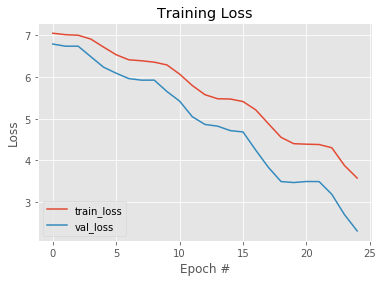

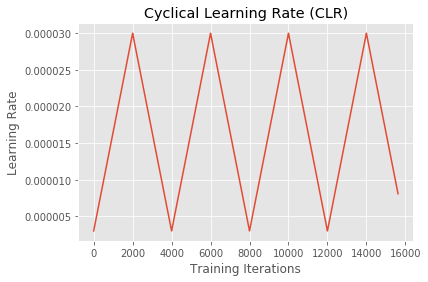

In [39]:
import matplotlib.pyplot as plt
N = np.arange(0, 25)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history2.history["loss"], label="train_loss")
plt.plot(N, history2.history["val_loss"], label="val_loss")
#plt.plot(N, history2.history["acc"], label="train_acc")
#plt.plot(N, history2.history["val_acc"], label="val_acc")
#plt.title("Training Loss and Accuracy")
plt.title("Training Loss")
plt.xlabel("Epoch #")
#plt.ylabel("Loss/Accuracy")
plt.ylabel("Loss")
plt.legend(loc="lower left")
#plt.savefig(os.path.sep.join(["output", "training_plot.png"]))
 
# plot the learning rate history
N = np.arange(0, len(clr_triangular2.history["lr"]))
plt.figure()
plt.plot(N, clr_triangular2.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")
#plt.savefig(os.path.sep.join(["output", "clr_plot.png"]))